In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [291]:
%autoreload

import numpy as np
import pickle

import main


import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc')

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.spectools as spectools

from darkhistory.spec.spectrum import Spectrum

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf_fast

from darkhistory.electrons import positronium

from scipy.interpolate import interp1d


In [117]:
test = positronium.weighted_photon_spec(photeng)
print(test.toteng()/phys.me)

2.000000000081069


# Marching Up Algorithm

In [3]:
ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()


********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

In [252]:
pickle.dump(ics_thomson_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "wb"))
pickle.dump(ics_rel_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "wb"))
pickle.dump(engloss_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "wb"))

In [293]:
eleceng = 10**np.arange(0, np.log10(5e12), 0.0254)
photeng = 10**np.arange(-4, np.log10(5e12), 0.0334)


rs = 30
xe = .01

test_nB = get_elec_cooling_tf_fast(
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    eleceng, photeng, rs, xe, xHe=0, check_conservation_eng=True, verbose=True
)

***************************************************
rs:  30
injected energy:  3018.5613014197993
Energy in low energy electrons:  2917.261881773852
Energy in photons:  172.46561998914797
Continuum_engloss:  169.77944913328088
Energy in photons - Continuum:  2.68617085586709
Deposited in ionization:  51.796530885815756
Deposited in excitation:  35.94440574112
Deposited in heating:  10.876409067750972
Energy is conserved up to (%):  -0.00013572375040746967
Deposited in ICS:  -0.004096904605654129
Energy conservation with deposited (%):  -3.2510448439395366e-14
***************************************************
***************************************************
rs:  30
injected energy:  3200.368594586517
Energy in low energy electrons:  2997.836763432164
Energy in photons:  348.5634441959563
Continuum_engloss:  342.9629536426453
Energy in photons - Continuum:  5.600490553311033
Deposited in ionization:  103.4068069776408
Deposited in excitation:  71.87840504932203
Deposited in heating: 

***************************************************
rs:  30
injected energy:  18501.204347718587
Energy in low energy electrons:  10127.765582833648
Energy in photons:  20869.64921930472
Continuum_engloss:  19665.66626347897
Energy in photons - Continuum:  1203.982955825748
Deposited in ionization:  3715.370765083041
Deposited in excitation:  2728.888657160239
Deposited in heating:  725.64743241748
Energy is conserved up to (%):  -0.002437925624138276
Deposited in ICS:  -0.4510456015610388
Energy conservation with deposited (%):  -3.338913410833483e-14
***************************************************
***************************************************
rs:  30
injected energy:  19615.527877010823
Energy in low energy electrons:  10612.337428113367
Energy in photons:  22681.732921928036
Continuum_engloss:  21307.53686444421
Energy in photons - Continuum:  1374.1960574838267
Deposited in ionization:  3951.3070328732306
Deposited in excitation:  2907.5833677014766
Deposited in heating: 

***************************************************
rs:  30
injected energy:  50003.45349769783
Energy in low energy electrons:  21602.019104255174
Energy in photons:  78530.3708173169
Continuum_engloss:  68187.9575277747
Energy in photons - Continuum:  10342.413289542194
Deposited in ionization:  9261.479622339402
Deposited in excitation:  7007.623335030999
Deposited in heating:  1791.456741991915
Energy is conserved up to (%):  -0.0030769783969484175
Deposited in ICS:  -1.5385954618177906
Energy conservation with deposited (%):  -6.9034228550723e-14
***************************************************
***************************************************
rs:  30
injected energy:  53015.15066784589
Energy in low energy electrons:  22483.58629581919
Energy in photons:  84354.16512034141
Continuum_engloss:  72720.11189264008
Energy in photons - Continuum:  11634.053227701326
Deposited in ionization:  9685.038504855083
Deposited in excitation:  7339.483995953429
Deposited in heating:  1874.

***************************************************
rs:  30
injected energy:  161064.563517827
Energy in low energy electrons:  40133.19563042367
Energy in photons:  280664.6092079845
Continuum_engloss:  195652.7663864281
Energy in photons - Continuum:  85011.84282155643
Deposited in ionization:  18156.28823224178
Deposited in excitation:  14093.387286698906
Deposited in heating:  3674.209371293502
Energy is conserved up to (%):  -0.002706879956772726
Deposited in ICS:  -4.359824387214753
Energy conservation with deposited (%):  -7.002271725615092e-14
***************************************************
***************************************************
rs:  30
injected energy:  170765.44728138752
Energy in low energy electrons:  40968.77920360412
Energy in photons:  296576.5509715449
Continuum_engloss:  203519.98677361486
Energy in photons - Continuum:  93056.56419793001
Deposited in ionization:  18556.757481493292
Deposited in excitation:  14417.800090959134
Deposited in heating:  37

***************************************************
rs:  30
injected energy:  1176521.8576672259
Energy in low energy electrons:  55342.91095393225
Energy in photons:  1505922.9263406866
Continuum_engloss:  436353.24685592036
Energy in photons - Continuum:  1069569.6794847662
Deposited in ionization:  25437.789493006367
Deposited in excitation:  20085.124955152893
Deposited in heating:  6095.989849003431
Energy is conserved up to (%):  -0.0008191151377619379
Deposited in ICS:  -9.63706863528497
Energy conservation with deposited (%):  4.654678078863188e-15
***************************************************
***************************************************
rs:  30
injected energy:  1247383.5142429431
Energy in low energy electrons:  55466.848281552
Energy in photons:  1581428.530261078
Continuum_engloss:  441272.711072887
Energy in photons - Continuum:  1140155.8191881909
Deposited in ionization:  25497.06727658453
Deposited in excitation:  20135.229751683994
Deposited in heating:  6

***************************************************
rs:  30
injected energy:  8594092.029532824
Energy in low energy electrons:  56711.19808913191
Energy in photons:  9013926.090450868
Continuum_engloss:  530156.989981869
Energy in photons - Continuum:  8483769.100468999
Deposited in ionization:  26092.190063393693
Deposited in excitation:  20643.214049287762
Deposited in heating:  6888.019696543985
Energy is conserved up to (%):  -0.00013605665953322178
Deposited in ICS:  -11.692834529618505
Energy conservation with deposited (%):  -3.4613535990310716e-14
***************************************************
***************************************************
rs:  30
injected energy:  9111712.330429193
Energy in low energy electrons:  56715.70414898164
Energy in photons:  9532627.77787524
Continuum_engloss:  531256.1841552691
Energy in photons - Continuum:  9001371.593719972
Deposited in ionization:  26094.345086925747
Deposited in excitation:  20645.096031715788
Deposited in heating:  

Deposited in heating:  7014.37277305242
Energy is conserved up to (%):  -3.559943576320022e-05
Deposited in ICS:  -11.744732071386483
Energy conservation with deposited (%):  -6.72812743214011e-14
***************************************************
***************************************************
rs:  30
injected energy:  34978404.84251412
Energy in low energy electrons:  56751.54609145743
Energy in photons:  35400185.14579533
Continuum_engloss:  532308.7992627787
Energy in photons - Continuum:  34867876.34653255
Deposited in ionization:  26111.48678407411
Deposited in excitation:  20660.158509393506
Deposited in heating:  7017.04979194601
Energy is conserved up to (%):  -3.3578418911872905e-05
Deposited in ICS:  -11.745195282751068
Energy conservation with deposited (%):  -6.849701086583957e-14
***************************************************
***************************************************
rs:  30
injected energy:  37085146.58756857
Energy in low energy electrons:  56751.864

***************************************************
rs:  30
injected energy:  240990542.86865932
Energy in low energy electrons:  56754.456196410894
Energy in photons:  241412279.52806562
Continuum_engloss:  532309.731328065
Energy in photons - Continuum:  240879969.79673755
Deposited in ionization:  26112.87864777178
Deposited in excitation:  20661.403274057335
Deposited in heating:  7056.089219890939
Energy is conserved up to (%):  -4.877957538024894e-06
Deposited in ICS:  -11.755416442903295
Energy conservation with deposited (%):  3.780829434509096e-14
***************************************************
***************************************************
rs:  30
injected energy:  255505351.05132562
Energy in low energy electrons:  56754.463754545155
Energy in photons:  255927087.30697185
Continuum_engloss:  532309.7337887969
Energy in photons - Continuum:  255394777.57318306
Deposited in ionization:  26112.882262950763
Deposited in excitation:  20661.40655939914
Deposited in heatin

Energy in photons:  981265867.3341384
Continuum_engloss:  532309.7527535118
Energy in photons - Continuum:  980733557.5813849
Deposited in ionization:  26112.910016777572
Deposited in excitation:  20661.431886399238
Deposited in heating:  7061.345631361541
Energy is conserved up to (%):  -1.1989459195223344e-06
Deposited in ICS:  -11.759791242753247
Energy conservation with deposited (%):  5.066417627790156e-14
***************************************************
***************************************************
rs:  30
injected energy:  1039920165.8290579
Energy in low energy electrons:  56754.52226596973
Energy in photons:  1040341897.031981
Continuum_engloss:  532309.7529144553
Energy in photons - Continuum:  1039809587.2790666
Deposited in ionization:  26112.910250401233
Deposited in excitation:  20661.432101463142
Deposited in heating:  7061.444822977387
Energy is conserved up to (%):  -1.1308030914318031e-06
Deposited in ICS:  -11.759449532399657
Energy conservation with deposit

***************************************************
rs:  30
injected energy:  4757732275.412052
Energy in low energy electrons:  56754.52609282035
Energy in photons:  4758154005.312861
Continuum_engloss:  532309.7541798558
Energy in photons - Continuum:  4757621695.5586815
Deposited in ionization:  26112.91208097129
Deposited in excitation:  20661.433793021213
Deposited in heating:  7062.748585951924
Energy is conserved up to (%):  -2.473275318166607e-07
Deposited in ICS:  -11.767182254652397
Energy conservation with deposited (%):  9.404293764538637e-15
***************************************************
***************************************************
rs:  30
injected energy:  5044289459.52414
Energy in low energy electrons:  56754.526115114386
Energy in photons:  5044711189.40468
Continuum_engloss:  532309.7541872843
Energy in photons - Continuum:  5044178879.650493
Deposited in ionization:  26112.91209163601
Deposited in excitation:  20661.43380296266
Deposited in heating:  7062

***************************************************
***************************************************
rs:  30
injected energy:  29160837985.21234
Energy in low energy electrons:  56754.52629331053
Energy in photons:  29161259714.804756
Continuum_engloss:  532309.754246862
Energy in photons - Continuum:  29160727405.05051
Deposited in ionization:  26112.912176880316
Deposited in excitation:  20661.433882699585
Deposited in heating:  7063.065171706674
Energy is conserved up to (%):  -4.038188168218893e-08
Deposited in ICS:  -11.775654653399036
Energy conservation with deposited (%):  -1.3867682485209308e-13
***************************************************
***************************************************
rs:  30
injected energy:  30917188938.916977
Energy in low energy electrons:  56754.52629395951
Energy in photons:  30917610668.506752
Continuum_engloss:  532309.7542470807
Energy in photons - Continuum:  30917078358.752506
Deposited in ionization:  26112.912177190785
Deposited in

***************************************************
rs:  30
injected energy:  200909281260.87238
Energy in low energy electrons:  56754.52629924193
Energy in photons:  200909702990.42017
Continuum_engloss:  532309.7542488695
Energy in photons - Continuum:  200909170680.66592
Deposited in ionization:  26112.912179717867
Deposited in excitation:  20661.433885384824
Deposited in heating:  7063.121770113374
Energy is conserved up to (%):  -5.867170435539403e-09
Deposited in ICS:  -11.787798784324151
Energy conservation with deposited (%):  5.416968835717495e-14
***************************************************
***************************************************
rs:  30
injected energy:  213010003741.12524
Energy in low energy electrons:  56754.52629925811
Energy in photons:  213010425470.67282
Continuum_engloss:  532309.7542488748
Energy in photons - Continuum:  213009893160.91858
Deposited in ionization:  26112.91217972561
Deposited in excitation:  20661.433885392213
Deposited in heatin

***************************************************
rs:  30
injected energy:  919178801694.4913
Energy in low energy electrons:  56754.526299389705
Energy in photons:  919179223424.0364
Continuum_engloss:  532309.7542489197
Energy in photons - Continuum:  919178691114.2821
Deposited in ionization:  26112.912179788556
Deposited in excitation:  20661.433885452447
Deposited in heating:  7063.130827902909
Energy is conserved up to (%):  -1.2830920081852096e-09
Deposited in ICS:  -11.79385855721753
Energy conservation with deposited (%):  -5.5689118341087e-15
***************************************************
***************************************************
rs:  30
injected energy:  974540741766.3053
Energy in low energy electrons:  56754.52629939071
Energy in photons:  974541163495.8529
Continuum_engloss:  532309.75424892
Energy in photons - Continuum:  974540631186.0986
Deposited in ionization:  26112.912179789044
Deposited in excitation:  20661.433885452916
Deposited in heating:  706

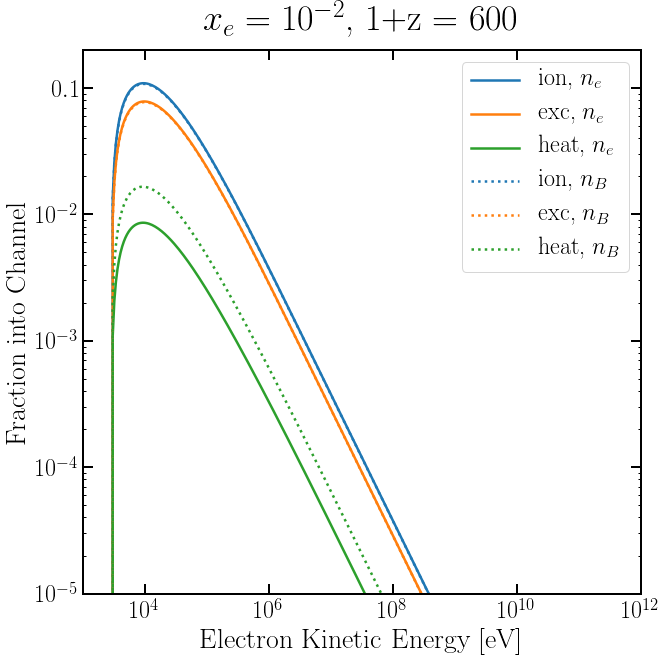

In [287]:
plt.figure()

ax = plt.gca()
ax.loglog()

plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Fraction into Channel')
plt.title(r'$x_e = 10^{-2}$, 1+z = 600')

plt.axis([1e3, 1e12, 1e-5, 0.2])

plt.plot(eleceng, b_ne[2]/eleceng, label=r'ion, $n_e$', color='C0')
plt.plot(eleceng, b_ne[3]/eleceng, label=r'exc, $n_e$', color='C1')
plt.plot(eleceng, b_ne[4]/eleceng, label=r'heat, $n_e$', color='C2')
plt.plot(eleceng, b_nB[2]/eleceng, label=r'ion, $n_B$', color='C0', linestyle=':')
plt.plot(eleceng, b_nB[3]/eleceng, label=r'exc, $n_B$', color='C1', linestyle=':')
plt.plot(eleceng, b_nB[4]/eleceng, label=r'heat, $n_B$', color='C2', linestyle=':')

plt.legend()

In [275]:
?plt.xlabel